# Interest-rate curves #
## 10. Interest-rate sensitivities via zero spread ##

In [1]:
import QuantLib as ql
today = ql.Date(8, ql.March, 2016)
ql.Settings.instance().evaluationDate = today

In [2]:
def format_rate(r):
    return f'{r * 100:.02}%'

In [7]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def plot_curves(*curves):
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda r,pos: format_rate(r)))
    ax.set_xlim(0, 15)
    ax.set_xticks([0, 5, 10, 15])
    times = numpy.linspace(0.0, 15.0, 400)
    for curve, style in curves:
        rates = [curve.zeroRate(t, ql.Continuous).rate() for t in times]
        plt.plot(times, rates, style)
def plot_curve(curve):
    plot_curves((curve,'-'))

### Setup ###

In [5]:
quotes = [ql.SimpleQuote(0.312 / 100) ]
helpers = [ql.DepositRateHelper(ql.QuoteHandle(quotes[0]),
                                ql.Period(6, ql.Months), 3,
                                ql.TARGET(), ql.Following, False, ql.Actual360())]
for rate, months_to_start in [(0.293, 1), (0.272, 2), (0.260, 3),
                              (0.256, 4), (0.252, 5), (0.248, 6),
                              (0.254, 7), (0.261, 8), (0.267, 9),
                              (0.279, 10), (0.291, 11), (0.303, 12),
                              (0.318, 13), (0.335, 14), (0.352, 15),
                              (0.371, 16), (0.389, 17), (0.409, 18)]:
    quotes.append(ql.SimpleQuote(rate / 100))
    helpers.append(ql.FraRateHelper(ql.QuoteHandle(quotes[-1]),
                                    months_to_start, ql.Euribor6M()))
for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5), (0.954, 6),
                    (1.135, 7), (1.303, 8), (1.452, 9), (1.584, 10),
                    (1.809, 12), (2.037, 15), (2.187, 20), (2.234, 25),
                    (2.256, 30), (2.295, 35), (2.348, 40), (2.421, 50),
                    (2.463, 60)]:
    quotes.append(ql.SimpleQuote(rate / 100))
    helpers.append(ql.SwapRateHelper(ql.QuoteHandle(quotes[-1]),
                                     ql.Period(tenor, ql.Years), ql.TARGET(),
                                     ql.Annual, ql.Unadjusted, 
                                     ql.Thirty360(ql.Thirty360.BondBasis),
                                     ql.Euribor6M()))
rate_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())
curve_handle = ql.RelinkableYieldTermStructureHandle(rate_curve)

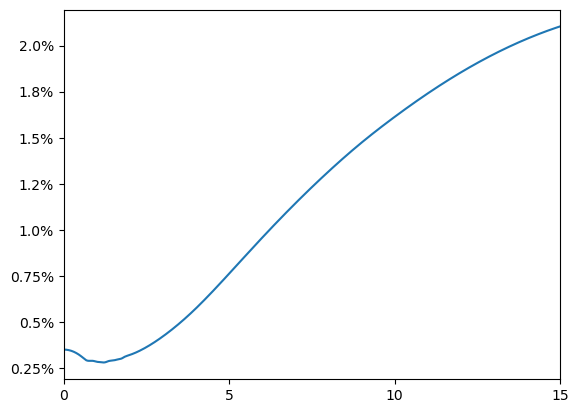

In [8]:
plot_curve(rate_curve)

In [9]:
fixed_schedule = ql.Schedule(ql.Date(8, ql.April, 2016), ql.Date(8, ql.April, 2028),
                             ql.Period(1, ql.Years), ql.TARGET(), ql.Following, ql.Following,
                             ql.DateGeneration.Forward, False)
floating_schedule = ql.Schedule(ql.Date(8, ql.April, 2016), ql.Date(8, ql.April, 2028),
                                ql.Period(6, ql.Months), ql.TARGET(), ql.Following, ql.Following,
                                ql.DateGeneration.Forward, False)
index = ql.Euribor6M(curve_handle)
swap = ql.VanillaSwap(ql.VanillaSwap.Payer, 10000.0,
                      fixed_schedule, 0.02, ql.Thirty360(ql.Thirty360.European),
                      floating_schedule, index, 0.0, ql.Actual360())

In [10]:
swap.setPricingEngine(ql.DiscountingSwapEngine(curve_handle))
P0 = swap.NPV()
print(P0)

-189.83267948709272


### Interest-rate sensitivities ###

In [11]:
bp = 1.0e-4
ref = quotes[0].value()
quotes[0].setValue(ref + 1 * bp)
print(swap.NPV())
quotes[0].setValue(ref)

-190.1069970119836


In [12]:
for q in quotes:
    q.setValue(q.value() + 1 * bp)
print(swap.NPV())
for q in quotes:
    q.setValue(q.value() - 1 * bp)

-178.68820577843803


In [14]:
base_curve = ql.YieldTermStructureHandle(rate_curve)
spread = ql.SimpleQuote(1 * bp)
curve_handle.linkTo(ql.ZeroSpreadedTermStructure(base_curve, ql.QuoteHandle(spread)))
print(swap.NPV())

-178.8676404436858


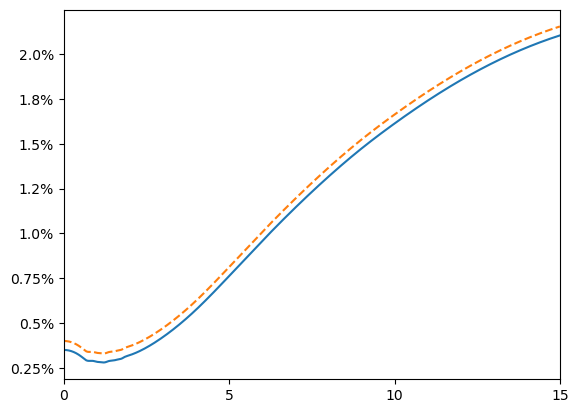

In [15]:
spread.setValue(5 * bp)
plot_curves((rate_curve,'-'), (curve_handle,'--'))

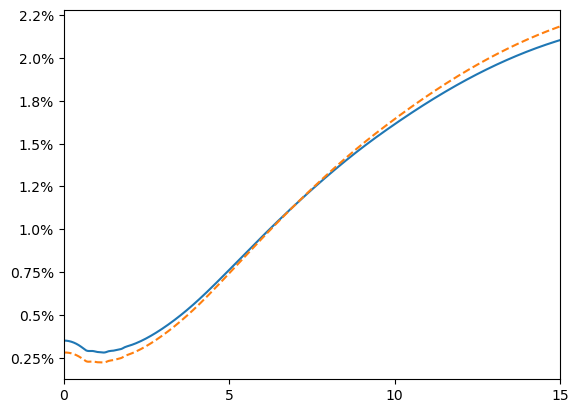

In [16]:
spot = rate_curve.referenceDate()
dates = [spot + ql.Period(n, ql.Years) for n in range(21)]
spreads = [ql.QuoteHandle(ql.SimpleQuote((n - 7) * bp)) for n in range(21)]
curve_handle.linkTo(ql.SpreadedLinearZeroInterpolatedTermStructure(base_curve, spreads, dates))
plot_curves((rate_curve,'-'), (curve_handle,'--'))

In [17]:
print(swap.NPV())

-138.69485276964406


In [18]:
curve_handle.linkTo(rate_curve)
print(swap.NPV())

-189.83267949204537
